# Linear Modeling in Python

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot, qqplot
from statsmodels.stats.api import anova_lm

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline

# Example 1: IT Salary Data

# Get the Data

In [5]:
url = 'http://stats191.stanford.edu/data/salary.table'
salary_table = pd.read_table(url) # needs pandas 0.7.3
#salary_table.to_csv('salary.table', index=False)

# Inspect the Data

In [6]:
print(salary_table.head(10))

       S  X  E  M
0  13876  1  1  1
1  11608  1  3  0
2  18701  1  3  1
3  11283  1  2  0
4  11767  1  3  0
5  20872  2  2  1
6  11772  2  2  0
7  10535  2  1  0
8  12195  2  3  0
9  12313  3  2  0


In [7]:
E = salary_table.E # Education
M = salary_table.M # Management
X = salary_table.X # Experience
S = salary_table.S # Salary

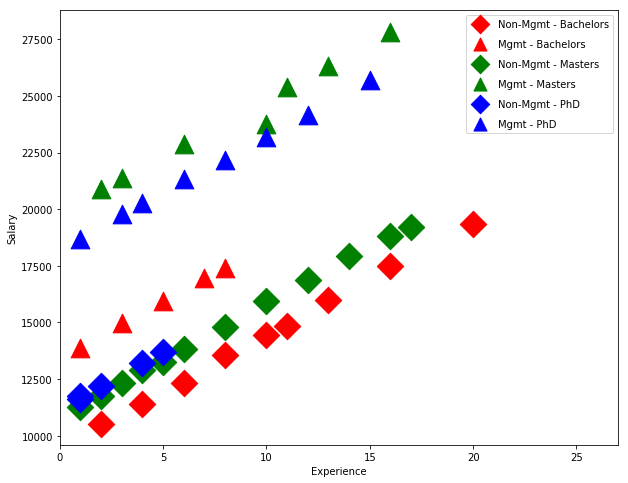

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary',
            xlim=(0, 27), ylim=(9600, 28800))
symbols = ['D', '^']
man_label = ["Non-Mgmt", "Mgmt"]
educ_label = ["Bachelors", "Masters", "PhD"]
colors = ['r', 'g', 'blue']
factor_groups = salary_table.groupby(['E','M'])
for values, group in factor_groups:
    i,j = values
    label = "%s - %s" % (man_label[j], educ_label[i-1])
    ax.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1],
               s=350, label=label)
ax.legend(scatterpoints=1, markerscale=.7, labelspacing=1);

# Define and Fit a Linear Model

$$S_i = \beta_0 + \beta_1X_i + \beta_2E_{i2} + \beta_3E_{i3} + \beta_4M_i + \epsilon_i$$

where
$$ E_{i2}=\cases{1,&if $E_i=2$;\cr 0,&otherwise. \cr}$$ 
$$ E_{i3}=\cases{1,&if $E_i=3$;\cr 0,&otherwise. \cr}$$ 

In [10]:
formula = 'S ~ C(E) + C(M) + X'
lm = ols(formula, salary_table).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Sun, 20 May 2018   Prob (F-statistic):           2.23e-27
Time:                        12:43:41   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

# Inspect the Design Matrix, and Demonstrate the Model Predictions

In [11]:
lm.model.exog[:10]

array([[ 1.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  2.],
       [ 1.,  1.,  0.,  0.,  2.],
       [ 1.,  0.,  0.,  0.,  2.],
       [ 1.,  0.,  1.,  0.,  2.],
       [ 1.,  1.,  0.,  0.,  3.]])

In [12]:
print(lm.model.data.orig_exog.head(10))

   Intercept  C(E)[T.2]  C(E)[T.3]  C(M)[T.1]    X
0        1.0        0.0        0.0        1.0  1.0
1        1.0        0.0        1.0        0.0  1.0
2        1.0        0.0        1.0        1.0  1.0
3        1.0        1.0        0.0        0.0  1.0
4        1.0        0.0        1.0        0.0  1.0
5        1.0        1.0        0.0        1.0  2.0
6        1.0        1.0        0.0        0.0  2.0
7        1.0        0.0        0.0        0.0  2.0
8        1.0        0.0        1.0        0.0  2.0
9        1.0        1.0        0.0        0.0  3.0


In [13]:
print(lm.model.data.frame.head(10))

       S  X  E  M
0  13876  1  1  1
1  11608  1  3  0
2  18701  1  3  1
3  11283  1  2  0
4  11767  1  3  0
5  20872  2  2  1
6  11772  2  2  0
7  10535  2  1  0
8  12195  2  3  0
9  12313  3  2  0


In [14]:
lm.predict(pd.DataFrame({'X' : [12], 'M' : [1], 'E' : [2]}))

0    24617.372072
dtype: float64

# Check the Residuals

In [15]:
resid = lm.resid

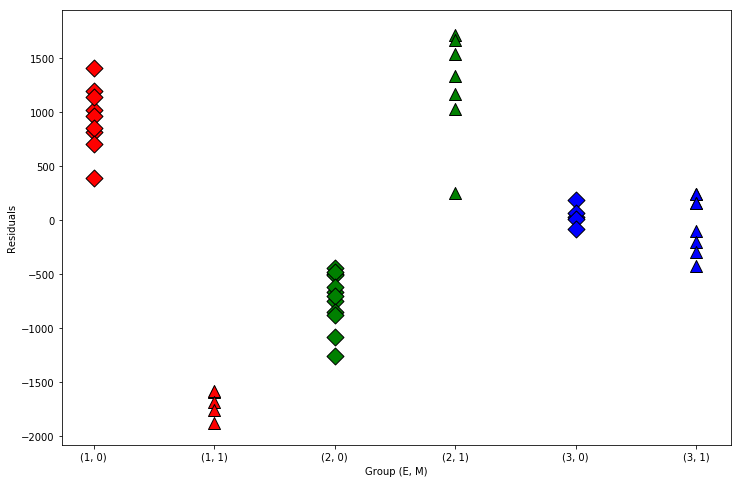

In [16]:
fig = plt.figure(figsize=(12,8))
xticks = []
ax = fig.add_subplot(111, xlabel='Group (E, M)', ylabel='Residuals')
for values, group in factor_groups:
    i,j = values
    xticks.append(str((i, j)))
    group_num = i*2 + j - 1 # for plotting purposes
    x = [group_num] * len(group)
    ax.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticks)
ax.axis('tight');

# Add an Interaction

### Interaction Salary*Experience

Add an interaction between salary and experience, allowing different intercepts for level of experience.
$$S_i = \beta_0+\beta_1X_i+\beta_2E_{i2}+\beta_3E_{i3}+\beta_4M_i+\beta_5E_{i2}X_i+\beta_6E_{i3}X_i+\epsilon_i$$

In [17]:
interX_lm = ols('S ~ C(E)*X + C(M)', salary_table).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Sun, 20 May 2018   Prob (F-statistic):           8.23e-26
Time:                        12:54:40   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

The "Factor" Experience has the "Treatments" (or elements) "1", "2", and "3". Since the "Treatment 1"([T.1]) is taken as the reference, it is not listed here explicitly. This is called "corner-point" approach. Similarly, the "Factor" Management has the "Treatments" "0" and "1". With "0" taken as the reference, only the term C(M)[T.1] is listed in the model. The interactions are described by the terms "C(E)[T.i]:X".

### Test the Interaction Management*Experience

Test that $\beta_5 = \beta_6 = 0$. We can use anova_lm or we can use an F-test.

In [18]:
print(anova_lm(lm, interX_lm))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      41.0  4.328072e+07      0.0           NaN       NaN       NaN
1      39.0  3.941068e+07      2.0  3.870040e+06  1.914856  0.160964


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [19]:
print(interX_lm.f_test('C(E)[T.2]:X = C(E)[T.3]:X = 0'))

<F test: F=array([[ 1.91485593]]), p=0.16096422424743717, df_denom=39, df_num=2>


In [20]:
print(interX_lm.f_test([[0,0,0,0,0,1,-1],[0,0,0,0,0,0,1]]))

<F test: F=array([[ 1.91485593]]), p=0.16096422424743717, df_denom=39, df_num=2>


Both tests show that the models are not significantly different. In other words, there is no interaction effect between Management and Experience in the data.

The contrasts are created here under the hood by patsy.

Recall that F-tests are of the form $R\beta = q$

In [21]:
LC = interX_lm.model.data.orig_exog.design_info.linear_constraint('C(E)[T.2]:X = C(E)[T.3]:X = 0')
print(LC.coefs)
print(LC.constants)

[[ 0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
[[ 0.]
 [ 0.]]


### Interact Education with Management

In [22]:
interM_lm = ols('S ~ X + C(E)*C(M)', salary_table).fit()
print(interM_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Sun, 20 May 2018   Prob (F-statistic):           1.67e-55
Time:                        12:57:48   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9472.6854    

In [23]:
print(anova_lm(lm, interM_lm))

   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0      41.0  4.328072e+07      0.0           NaN         NaN           NaN
1      39.0  1.178168e+06      2.0  4.210255e+07  696.844466  3.025504e-31


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The interaction effect Management*Education is highly significant!

### Check the Residuals of the Extended Model

In [25]:
infl = interM_lm.get_influence()
resid = infl.resid_studentized_internal

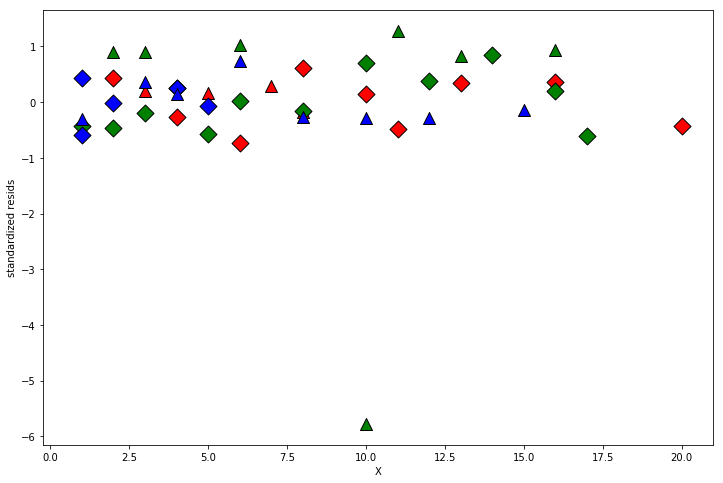

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

### Find and Remove the Outlier

In [27]:
outl = interM_lm.outlier_test('fdr_bh')
outl.sort('unadj_p', inplace=True)
print(outl)

AttributeError: 'DataFrame' object has no attribute 'sort'

In [28]:
idx = salary_table.index.drop(32)

In [29]:
print(idx)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
           dtype='int64')


### Rerun the Original Linear Model without the Outlier

In [30]:
lm32 = ols('S ~ C(E) + X + C(M)', data=salary_table, subset=idx).fit()
print(lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     211.7
Date:                Sun, 20 May 2018   Prob (F-statistic):           2.45e-26
Time:                        13:01:29   Log-Likelihood:                -373.79
No. Observations:                  45   AIC:                             757.6
Df Residuals:                      40   BIC:                             766.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8044.7518    392.781     20.482      0.0

### Interaction of Education*Experience

In [31]:
interX_lm32 = ols('S ~ C(E) * X + C(M)', data=salary_table, subset=idx).fit()
print(interX_lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     147.7
Date:                Sun, 20 May 2018   Prob (F-statistic):           8.97e-25
Time:                        13:02:09   Log-Likelihood:                -371.70
No. Observations:                  45   AIC:                             757.4
Df Residuals:                      38   BIC:                             770.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7266.0887    558.872     13.001      

In [32]:
table3 = anova_lm(lm32, interX_lm32)
print(table3)

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      40.0  4.320910e+07      0.0           NaN       NaN       NaN
1      38.0  3.937424e+07      2.0  3.834859e+06  1.850508  0.171042


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Final Result

Result from the Interaction Test: the significant model with Interaction Experience*Management, without the outlier #32

In [33]:
interM_lm32 = ols('S ~ X + C(E) * C(M)', data=salary_table, subset=idx).fit()
print(anova_lm(lm32, interM_lm32))

   df_resid           ssr  df_diff       ss_diff            F        Pr(>F)
0      40.0  4.320910e+07      0.0           NaN          NaN           NaN
1      38.0  1.711881e+05      2.0  4.303791e+07  4776.734853  2.291239e-46


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


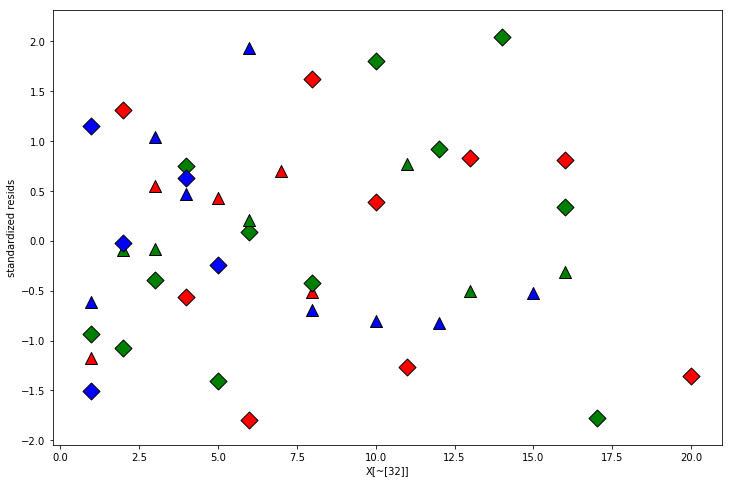

In [34]:
resid = interM_lm32.get_influence().summary_frame()['standard_resid']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X[~[32]]', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

A final plot of the fitted values

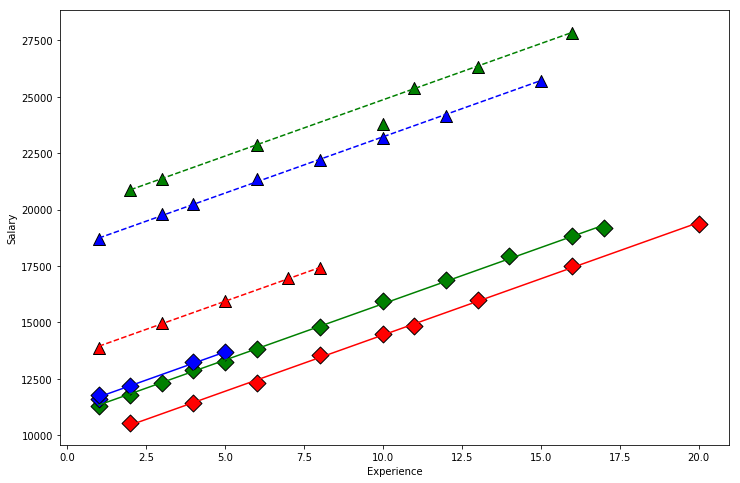

In [35]:
lm_final = ols('S ~ X + C(E)*C(M)', data=salary_table.drop([32])).fit()
mf = lm_final.model.data.orig_exog
lstyle = ['-','--']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], S[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
    # drop NA because there is no idx 32 in the final model
    ax.plot(mf.X[idx].dropna(), lm_final.fittedvalues[idx].dropna(),
            ls=lstyle[j], color=colors[i-1])
ax.axis('tight');

### Interaction Plot Salary | Experience

From our first look at the data, the difference between Master's and PhD in the management group is different than in the non-management group. This is an interaction between the two qualitative variables management, M and education, E. We can visualize this by first removing the effect of experience, then plotting the means within each of the 6 groups using interaction.plot.

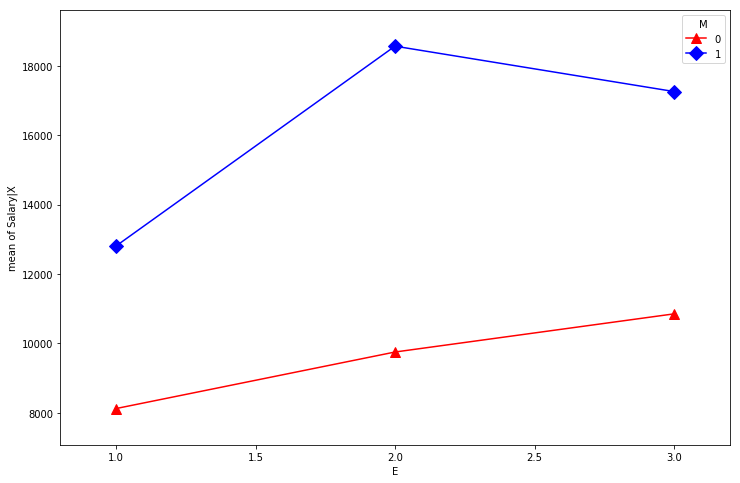

In [36]:
U = S - X * interX_lm32.params['X']
U.name = 'Salary|X'

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = interaction_plot(E, M, U, colors=['red','blue'], markers=['^','D'],
        markersize=10, ax=ax)

# Example 2: Minority Employment Data - ABLine Plotting

In [38]:
from urllib.request import urlopen
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_others/'
inFile = 'minority.table'
url = url_base + inFile
minority_table = pd.read_table(urlopen(url))
minority_table
#minority_table = pd.read_table(r'.\Data\data_others\minority.table')
minority_table.to_csv('minority.table', sep="\t", index=False)

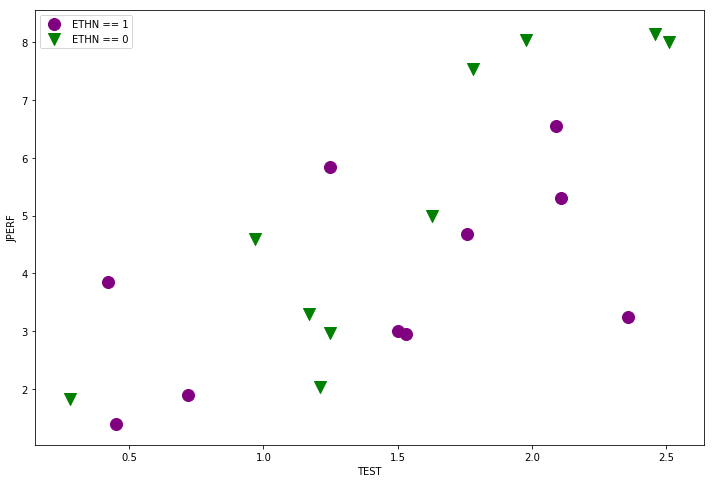

In [39]:
factor_group = minority_table.groupby(['ETHN'])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
colors = ['purple', 'green']
markers = ['o', 'v']
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1)

In [40]:
min_lm = ols('JPERF ~ TEST', data=minority_table).fit()
print(min_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.25
Date:                Sun, 20 May 2018   Prob (F-statistic):           0.000356
Time:                        13:10:57   Log-Likelihood:                -36.614
No. Observations:                  20   AIC:                             77.23
Df Residuals:                      18   BIC:                             79.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0350      0.868      1.192      0.2

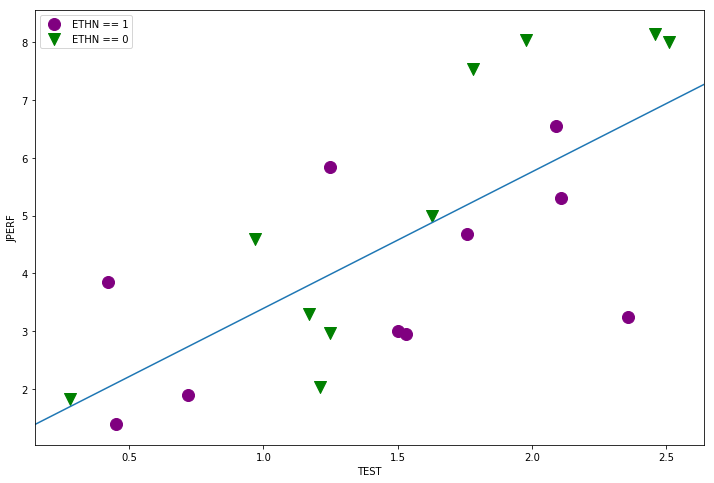

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')
fig = abline_plot(model_results = min_lm, ax=ax)

In [42]:
min_lm2 = ols('JPERF ~ TEST + TEST:ETHN', data=minority_table).fit()
print(min_lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.59
Date:                Sun, 20 May 2018   Prob (F-statistic):           0.000204
Time:                        13:11:25   Log-Likelihood:                -33.891
No. Observations:                  20   AIC:                             73.78
Df Residuals:                      17   BIC:                             76.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1211      0.780      1.437      0.1

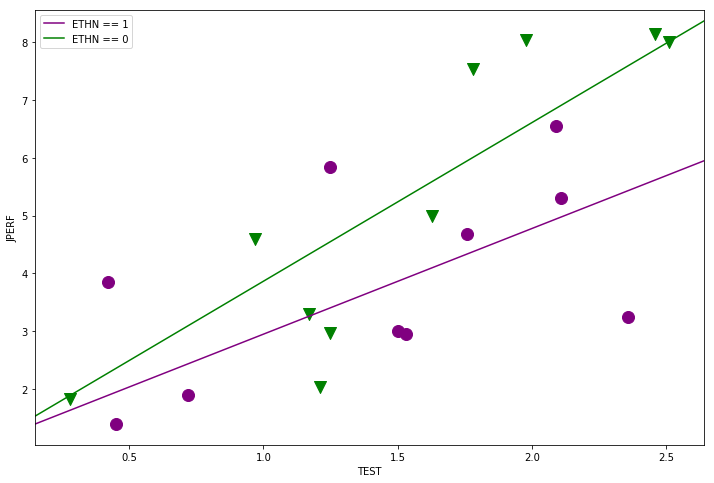

In [43]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm2.params['Intercept'],
                 slope = min_lm2.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm2.params['Intercept'],
        slope = min_lm2.params['TEST'] + min_lm2.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [44]:
min_lm3 = ols('JPERF ~ TEST + ETHN', data=minority_table).fit()
print(min_lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.38
Date:                Sun, 20 May 2018   Prob (F-statistic):           0.000731
Time:                        13:11:56   Log-Likelihood:                -35.390
No. Observations:                  20   AIC:                             76.78
Df Residuals:                      17   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6120      0.887      0.690      0.5

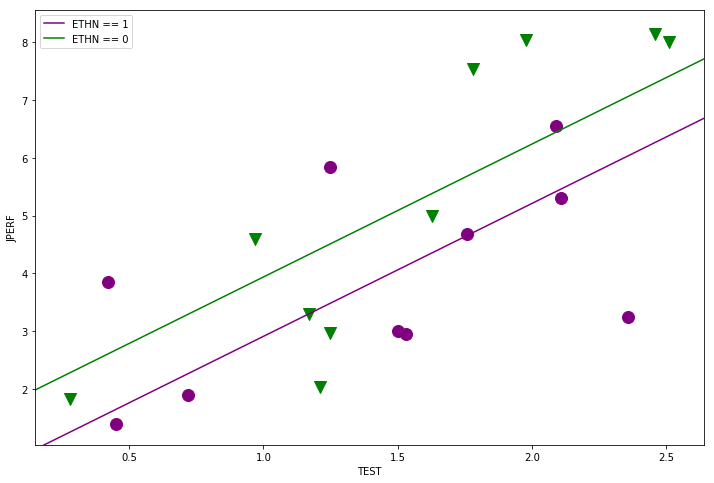

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm3.params['Intercept'],
                 slope = min_lm3.params['TEST'], ax=ax, color='purple')

ax = fig.axes[0]
fig = abline_plot(intercept = min_lm3.params['Intercept'] + min_lm3.params['ETHN'],
        slope = min_lm3.params['TEST'], ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [46]:
min_lm4 = ols('JPERF ~ TEST * ETHN', data=minority_table).fit()
print(min_lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Sun, 20 May 2018   Prob (F-statistic):           0.000451
Time:                        13:12:26   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0103      1.050      1.914      0.0

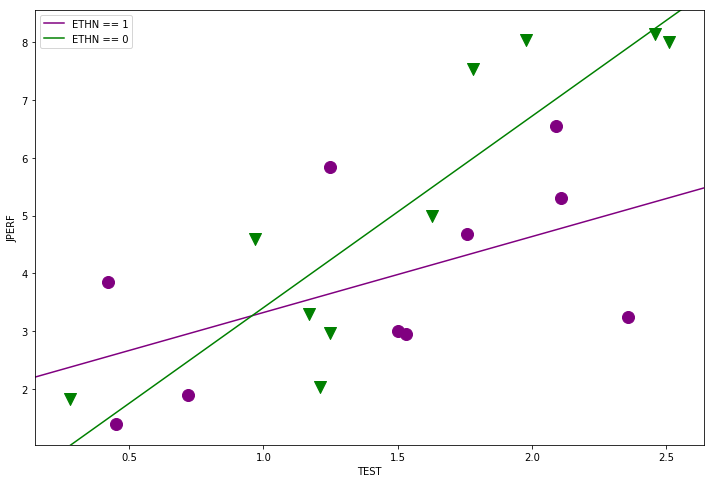

In [47]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, ylabel='JPERF', xlabel='TEST')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm4.params['Intercept'],
                 slope = min_lm4.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm4.params['Intercept'] + min_lm4.params['ETHN'],
        slope = min_lm4.params['TEST'] + min_lm4.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [49]:
table5 = anova_lm(min_lm, min_lm4)
print(table5)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      16.0  31.655473      2.0  13.912824  3.516061  0.054236


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [50]:
table6 = anova_lm(min_lm, min_lm3)
print(table6)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0       NaN       NaN       NaN
1      17.0  40.321546      1.0  5.246751  2.212087  0.155246


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [51]:
table7 = anova_lm(min_lm, min_lm2)
print(table7)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      17.0  34.707653      1.0  10.860644  5.319603  0.033949


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [52]:
table8 = anova_lm(min_lm2, min_lm4)
print(table8)

   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      17.0  34.707653      0.0      NaN       NaN       NaN
1      16.0  31.655473      1.0  3.05218  1.542699  0.232115


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Two - Way ANOVA : Kidney Failure Data

In [55]:
try:
    kidney_table = pd.read_table('kidney.table')
except:
    url = 'http://stats191.stanford.edu/data/kidney.table'
    kidney_table = pd.read_table(url, delimiter=" *")
    kidney_table.to_csv("kidney.table", sep="\t", index=False)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
C:\Users\user\Anaconda3\lib\site-packages\pandas\io\parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\user\Anaconda3\lib\site-packages\pandas\io\parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [56]:
# Explore the dataset, it's a balanced design
print(kidney_table.groupby(['Weight', 'Duration']).size())

Weight  Duration
1       1           10
        2           10
2       1           10
        2           10
3       1           10
        2           10
dtype: int64


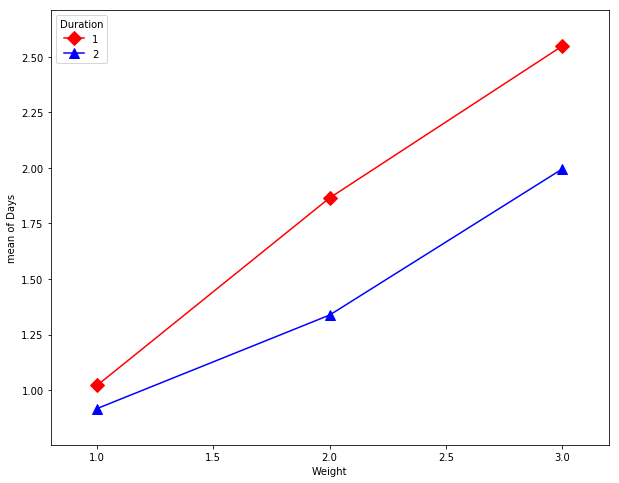

In [57]:
kt = kidney_table
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
fig = interaction_plot(kt['Weight'], kt['Duration'], np.log(kt['Days']+1),
        colors=['red', 'blue'], markers=['D','^'], ms=10, ax=ax)

$$Y_{ijk} = \mu + \alpha_i + \beta_j + \left(\alpha\beta\right)_{ij}+\epsilon_{ijk}$$

with 

$$\epsilon_{ijk}\sim N\left(0,\sigma^2\right)$$

In [58]:
help(anova_lm)

Help on function anova_lm in module statsmodels.stats.anova:

anova_lm(*args, **kwargs)
    ANOVA table for one or more fitted linear models.
    
    Parameters
    ----------
    args : fitted linear model results instance
        One or more fitted linear models
    scale : float
        Estimate of variance, If None, will be estimated from the largest
        model. Default is None.
    test : str {"F", "Chisq", "Cp"} or None
        Test statistics to provide. Default is "F".
    typ : str or int {"I","II","III"} or {1,2,3}
        The type of ANOVA test to perform. See notes.
    robust : {None, "hc0", "hc1", "hc2", "hc3"}
        Use heteroscedasticity-corrected coefficient covariance matrix.
        If robust covariance is desired, it is recommended to use `hc3`.
    
    Returns
    -------
    anova : DataFrame
    A DataFrame containing.
    
    Notes
    -----
    Model statistics are given in the order of args. Models must have
    been fit using the formula api.
    
   

In [59]:
kidney_lm = ols('np.log(Days+1) ~ C(Duration) * C(Weight)', data=kt).fit()

In [60]:
print(anova_lm(kidney_lm))

                         df     sum_sq   mean_sq          F    PR(>F)
C(Duration)             1.0   2.339693  2.339693   4.358293  0.041562
C(Weight)               2.0  16.971291  8.485645  15.806745  0.000004
C(Duration):C(Weight)   2.0   0.635658  0.317829   0.592040  0.556748
Residual               54.0  28.989198  0.536837        NaN       NaN


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [61]:
print(anova_lm(kidney_lm, typ=2))

                          sum_sq    df          F    PR(>F)
C(Duration)             2.339693   1.0   4.358293  0.041562
C(Weight)              16.971291   2.0  15.806745  0.000004
C(Duration):C(Weight)   0.635658   2.0   0.592040  0.556748
Residual               28.989198  54.0        NaN       NaN


In [62]:
print(anova_lm(ols('np.log(Days+1) ~ C(Duration, Sum) * C(Weight, Poly)', 
                   data=kt).fit(), typ=3))

                                      sum_sq    df           F        PR(>F)
Intercept                         156.301830   1.0  291.153237  2.077589e-23
C(Duration, Sum)                    2.339693   1.0    4.358293  4.156170e-02
C(Weight, Poly)                    16.971291   2.0   15.806745  3.944502e-06
C(Duration, Sum):C(Weight, Poly)    0.635658   2.0    0.592040  5.567479e-01
Residual                           28.989198  54.0         NaN           NaN


### Excercise: Find the 'best' model for the kidney failure dataset